# ======== 0. load the libraries ========

In [1]:
import pandas as pd
import numpy as np
import math
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Using TensorFlow backend.


# ========= 1. Clean and Prepare the data =========

In [2]:
data_train = pd.read_csv('class_exercise_05/exercise_05_train.csv')
data_test = pd.read_csv('class_exercise_05/exercise_05_test.csv')

#deal with the 'dollar' column (41): remove '$'
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        #exclude NaN which is float type
        if data.iloc[i, 41] is not np.nan and re.search('^\$.*', data.iloc[i, 41]):
            data.iloc[i, 41] = float(data.iloc[i, 41].lstrip('$'))

#deal with the percentage column (45): remove '%'
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        #exclude NaN
        if type(data.iloc[i, 45]) == type('str'):
            data.iloc[i, 45] = float(data.iloc[i, 45].rstrip('%'))

#deal with the day column (35): wed->wednesday, thur->thurday, fri->friday
correct_day = {'wed': 'wednesday', 'thur': 'thurday', 'fri': 'friday'}
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        #exclude NaN
        if type(data.iloc[i, 35]) == type('str') and data.iloc[i, 35] in correct_day:
            data.iloc[i, 35] = correct_day[data.iloc[i, 35]]
           
#deal with missing categorical data (34, 35, 68, 93)
#take a look how many valus are missing for each column
nulls_train = data_train.iloc[:, :-1].isnull().sum()
nulls_test = data_test.isnull().sum()
print ('Training set: missing data in columns 34, 35, 68 and 93:', nulls_train[34], nulls_train[35], nulls_train[68], nulls_train[93])
print ('Test set: missing data in columns 34, 35, 68 and 93:', nulls_test[34], nulls_test[35], nulls_test[68], nulls_test[93])
#we can find that the number of missing data is very small compared
#with the rest. Though in a sense that we can just neglect them, we
#will deal with such case.
#we will create a category called 'MISSING' to denote the missing data
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        for col in [34, 35, 68, 93]:
            if type(data.iloc[i, col]) == type(np.nan): #math.isnan(..) requires float type, not work for string
                data.iloc[i, col] = 'MISSING'

#now we are to convert categorical data using one hot encoders
data_train_arr = data_train.values
data_test_arr = data_test.values

#remove the categorical columns in the dataframe
data_train = data_train.drop(['x34', 'x35', 'x68', 'x93'], axis = 1)
data_test = data_test.drop(['x34', 'x35', 'x68', 'x93'], axis = 1)

coll_train = None
coll_test = None
for catg in [34, 35, 68, 93]:
    #fit and transform training set
    label_encoder = LabelEncoder()
    data_train_arr[:, catg] = label_encoder.fit_transform(data_train_arr[:, catg])
    encoder = OneHotEncoder(categorical_features = [0])
    labels_cat = pd.DataFrame(encoder.fit_transform(data_train_arr[:, catg: catg+1]).toarray())
    coll_train = pd.concat([coll_train, labels_cat], axis=1)
    coll_train = coll_train.iloc[:, 1:] #avoid dummy variable trap
    
    #tranform test set, no fitting
    data_test_arr[:, catg] = label_encoder.transform(data_test_arr[:, catg])
    labels_cat = pd.DataFrame(encoder.transform(data_test_arr[:, catg: catg+1]).toarray())
    coll_test = pd.concat([coll_test, labels_cat], axis=1)
    coll_test = coll_test.iloc[:, 1:] #avoid dummy variable trap

data_train = pd.concat([coll_train, data_train], axis = 1)    
data_test = pd.concat([coll_test, data_test], axis = 1)                           

#deal with the missing numerical values
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
data_train.iloc[:, :-1] = imputer.fit_transform(data_train.iloc[:, :-1])
data_test.iloc[:, :] = imputer.transform(data_test)

Training set: missing data in columns 34, 35, 68 and 93: 8 10 9 7
Test set: missing data in columns 34, 35, 68 and 93: 1 3 2 1


/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/_encoders

# =========== 2. model_1: Logistic Regression ====

/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Training statistics:
mean: 0.890475, std: 0.000657, params: {'logistic__C': 0.1}
mean: 0.890492, std: 0.000594, params: {'logistic__C': 0.2}
mean: 0.890489, std: 0.000568, params: {'logistic__C': 0.3}
mean: 0.890458, std: 0.000561, params: {'logistic__C': 0.5}
mean: 0.890483, std: 0.000598, params: {'logistic__C': 0.8}
mean: 0.890453, std: 0.000590, params: {'logistic__C': 1}

Testing statistics:
mean: 0.889075, std: 0.003201, params: {'logistic__C': 0.1}
mean: 0.889300, std: 0.003163, params: {'logistic__C': 0.2}
mean: 0.889425, std: 0.003229, params: {'logistic__C': 0.3}
mean: 0.889550, std: 0.003164, params: {'logistic__C': 0.5}
mean: 0.889400, std: 0.003141, params: {'logistic__C': 0.8}
mean: 0.889325, std: 0.003139, params: {'logistic__C': 1}
The best accuracy: 0.88955
The best parameters: {'logistic__C': 0.5}
>> High accuracy, and low variance.


/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


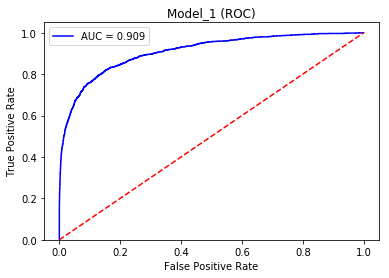

In [3]:
#To avoid data leakage in GridSearchCV, we utilize pipeline to facilitate 
#this. After GridSearchCV, we find the best parameters, which are used
#in the model trained on the whole training data set. The results for the test set are predicted and written to the file results1.csv. The ROC curve is plotted using 4000 data points in the training set. The similar procedures are applied to model_2 which is ANN.
estimators_1 = []
estimators_1.append(('standardize', StandardScaler()))
estimators_1.append(('logistic', LogisticRegression()))
model_1 = Pipeline(estimators_1)

#grid search to find the optimized C
np.random.seed(0) #random state in shuffling in KFold
param_grid = {'logistic__C': [ 0.1, 0.2, 0.3, 0.5, 0.8, 1]}
grid_search = GridSearchCV(estimator = model_1,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           return_train_score=True,
                           n_jobs = -1)
gs_1= grid_search.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1])

print ('\nTraining statistics:')
for mean, std, param in zip(gs_1.cv_results_['mean_train_score'], gs_1.cv_results_['std_train_score'], gs_1.cv_results_['params']):
    print("mean: %f, std: %f, params: %s" % (mean, std, param))

print ('\nTesting statistics:')
for mean, std, param in zip(gs_1.cv_results_['mean_test_score'], gs_1.cv_results_['std_test_score'], gs_1.cv_results_['params']):
    print("mean: %f, std: %f, params: %s" % (mean, std, param))

print('The best accuracy:', gs_1.best_score_)
print('The best parameters:', gs_1.best_params_)
print ('>> High accuracy, and low variance.')

#fit on the whole training data and predict the data_test
model_1.set_params(logistic__C=0.5)
model_1.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1])
y_pred_1 = model_1.predict(data_test)
y_pred_proba_1 = model_1.predict_proba(data_test)[:, 1]

#output the probabilities of class 1
with open('results1.csv', 'w') as f:
    for i in y_pred_proba_1:
        f.write(str(i)+'\n')
    
#create ROC curve for model_1
#split the training data set into sub-train and sub-test data sets to evaluate the model (ROC curve)
data_train_roc, data_test_roc = train_test_split(data_train, test_size = 0.2, random_state = 0)
model_1.fit(data_train_roc.iloc[:, :-1], data_train_roc.iloc[:, -1])
y_prob = model_1.predict_proba(data_test_roc.iloc[:, :-1])[:, 1]

fpr_1, tpr_1, threshold_1 = metrics.roc_curve(data_test_roc.iloc[:, -1], y_prob)

roc_auc_1 = metrics.auc(fpr_1, tpr_1)

plt.title('Model_1 (ROC)')
plt.plot(fpr_1, tpr_1, 'b', label = 'AUC = %0.3f' % roc_auc_1)
plt.legend(loc = 0)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# =========== 2. model_2: ANN =========

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your


Training statistics:
mean: 0.984688, std: 0.001211, params: {'ann__dropout': 0.5, 'ann__epochs': 30, 'ann__batch_size': 100}
mean: 0.985612, std: 0.001300, params: {'ann__dropout': 0.5, 'ann__epochs': 40, 'ann__batch_size': 100}
mean: 0.981750, std: 0.001907, params: {'ann__dropout': 0.6, 'ann__epochs': 30, 'ann__batch_size': 100}
mean: 0.982400, std: 0.000094, params: {'ann__dropout': 0.6, 'ann__epochs': 40, 'ann__batch_size': 100}
mean: 0.984763, std: 0.000187, params: {'ann__dropout': 0.5, 'ann__epochs': 30, 'ann__batch_size': 200}
mean: 0.986375, std: 0.000984, params: {'ann__dropout': 0.5, 'ann__epochs': 40, 'ann__batch_size': 200}
mean: 0.979650, std: 0.001002, params: {'ann__dropout': 0.6, 'ann__epochs': 30, 'ann__batch_size': 200}
mean: 0.983038, std: 0.001531, params: {'ann__dropout': 0.6, 'ann__epochs': 40, 'ann__batch_size': 200}

Testing statistics:
mean: 0.968925, std: 0.001172, params: {'ann__dropout': 0.5, 'ann__epochs': 30, 'ann__batch_size': 100}
mean: 0.968575, std: 

/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/LianshuiZhao/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

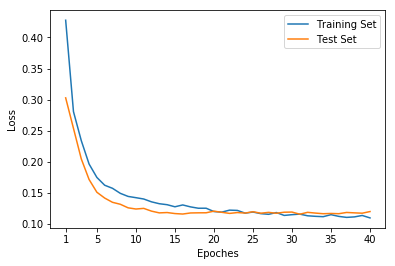

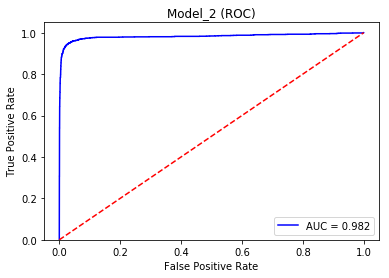

In [4]:
#the procedure is very similar to the one used in model_1. I used ANN method
#which took too much computaional time, so I did not explore too many 
#options in GridSearchCV. 

def build_classifier(dropout): 
    classifier = Sequential()
    classifier.add(Dense(units=50, kernel_initializer='uniform', activation='relu', input_dim = data_train.iloc[:, :-1].shape[1]))
    classifier.add(Dropout(p=dropout))  #reduce overfitting
    
    classifier.add(Dense(units=50, kernel_initializer='uniform', activation='relu')) 
    classifier.add(Dropout(p=dropout)) #reduce overfitting
    
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid')) 
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_classifier)


estimators_2 = []
estimators_2.append(('standardize', StandardScaler()))
estimators_2.append(('ann', classifier))
model_2 = Pipeline(estimators_2)


param_grid = {'ann__batch_size': [100, 200], 
              'ann__epochs':[30, 40],
              'ann__dropout':[0.5, 0.6]}
grid_search = GridSearchCV(estimator = model_2,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 1, #verbose here does not work well in pipeline
                           return_train_score=True,
                           n_jobs = 1) #n_job=-1 overwhelmed my computer
gs_2= grid_search.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1], ann__verbose = 0) #set verbose here

print ('\nTraining statistics:')
for mean, std, param in zip(gs_2.cv_results_['mean_train_score'], gs_2.cv_results_['std_train_score'], gs_2.cv_results_['params']):
    print("mean: %f, std: %f, params: %s" % (mean, std, param))

print ('\nTesting statistics:')    
for mean, std, param in zip(gs_2.cv_results_['mean_test_score'], gs_2.cv_results_['std_test_score'], gs_2.cv_results_['params']):
    print("mean: %f, std: %f, params: %s" % (mean, std, param))

print('The best accuracy:', gs_2.best_score_)
print('The best parameters:', gs_2.best_params_)
print ('>> High accuracy, and low variance.')

#fit on the whole training data and predict the data_test
model_2.set_params(ann__epochs=40, ann__batch_size = 200, ann__dropout = 0.5) 
model_2.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1], ann__verbose = 0) #mute the progress bar
y_pred_2 = model_2.predict(data_test)
y_pred_proba_2 = model_2.predict_proba(data_test)[:, 1]

#output the probabilities of class 1
with open('results2.csv', 'w') as f:
    for i in y_pred_proba_2:
        f.write(str(i)+'\n')
        
#create ROC curve for model_2
#history_2 = model_2.fit(data_train_roc.iloc[:, :-1], data_train_roc.iloc[:, -1], ann__validation_data=(data_test_roc.iloc[:, :-1], data_test_roc.iloc[:, -1]), ann__verbose = 0)  #can not extract history, so abandon this and use the normal method
sc = StandardScaler()
data_train_roc.iloc[:, :-1] = sc.fit_transform(data_train_roc.iloc[:, :-1])
data_test_roc.iloc[:, :-1] = sc.transform(data_test_roc.iloc[:, :-1])

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 200, epochs = 40, dropout = 0.5)
history_2 = classifier.fit(data_train_roc.iloc[:, :-1], data_train_roc.iloc[:, -1], validation_data=(data_test_roc.iloc[:, :-1], data_test_roc.iloc[:, -1]), 
                           verbose = 0)

#plot losses v.s. epoches
num_epoches = len(history_2.history['loss'])
plt.plot (history_2.history['loss'], label = 'Training Set')
plt.plot (history_2.history['val_loss'], label = 'Test Set')
plt.xticks([0]+list(range(4, num_epoches, 5)), labels = ['1']+[str(i) for i in range(5, 1+num_epoches, 5)])
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.legend()
plt.show()

y_prob_2 = classifier.predict_proba(data_test_roc.iloc[:, :-1])[:, 1]

fpr_2, tpr_2, threshold_2 = metrics.roc_curve(data_test_roc.iloc[:, -1], y_prob_2)

roc_auc_2 = metrics.auc(fpr_2, tpr_2)

plt.title('Model_2 (ROC)')
plt.plot(fpr_2, tpr_2, 'b', label = 'AUC = %0.3f' % roc_auc_2)
plt.legend(loc = 0)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ====== 3. Comparison of model_1 and model_2 =======

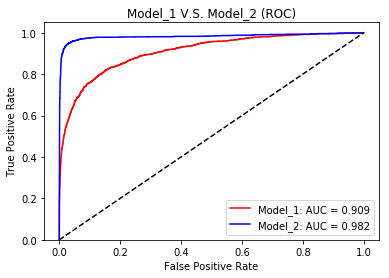

The accuracy of model_1 on data_test is 0.9029 , which is close to the best accuracy of model_1 in 10-fold CV 0.88955 .


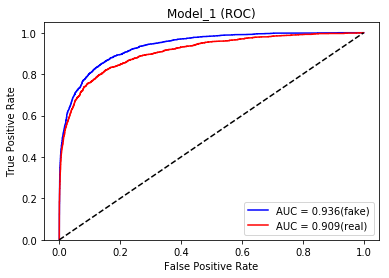

In [5]:
plt.title('Model_1 V.S. Model_2 (ROC)')
plt.plot(fpr_1, tpr_1, 'r', label = 'Model_1: AUC = %0.3f' % roc_auc_1)
plt.plot(fpr_2, tpr_2, 'b', label = 'Model_2: AUC = %0.3f' % roc_auc_2)
plt.legend(loc = 0)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#since the AUC_ROC of model_2 is close to 1, we can assume the prediction
#of model_2 is the ground truth, and assess the accuracy of model_1 as well as plot the ROC curve of model_1
cm_test = confusion_matrix(y_pred_1, y_pred_2[:, 0])
print ('The accuracy of model_1 on data_test is', (cm_test[0][0]+cm_test[1][1])/(sum(sum(cm_test))), ', which is close to the best accuracy of model_1 in 10-fold CV', gs_1.best_score_, '.')

fpr_3, tpr_3, threshold_3 = metrics.roc_curve(y_pred_2, y_pred_proba_1) #assume the ground truth is y_pred_2

roc_auc_3 = metrics.auc(fpr_3, tpr_3)

plt.title('Model_1 (ROC)')
plt.plot(fpr_3, tpr_3, 'b', label = 'AUC = %0.3f(fake)' % roc_auc_3)
plt.plot(fpr_1, tpr_1, 'r', label = 'AUC = %0.3f(real)' % roc_auc_1)
plt.legend(loc = 0)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()